<a href="https://colab.research.google.com/github/bachvu98/Policy-NLP/blob/master/Data_Retention_Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
import time
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from os import listdir
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from lxml import etree, html

%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
segments = pd.read_csv('/content/drive/My Drive/OPP-115/OPP-115/binary_segment_categories.csv',index_col=0)
segments = segments[['Policy UID','segment_id','segments','do_not_track']]
segments.head()

,Policy UID,segment_id,segments,do_not_track
0,20,0,strong privaci polici strong br br strong effe...,0
1,20,1,privaci polici appli site maintain compani org...,0
2,20,2,visit site accept practic describ privaci poli...,0
3,20,3,strong inform collect strong br br collect two...,0
4,20,4,strong person identifi inform strong br br gen...,0


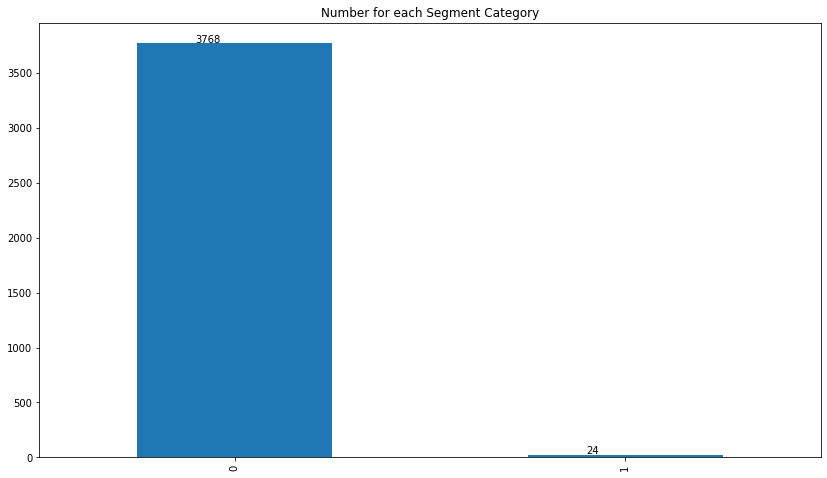

In [7]:
ax = segments['do_not_track'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Segment Category")

for index, value in enumerate(segments['do_not_track'].value_counts()):
    ax.text(index-0.1, value+10, "{}".format(value))

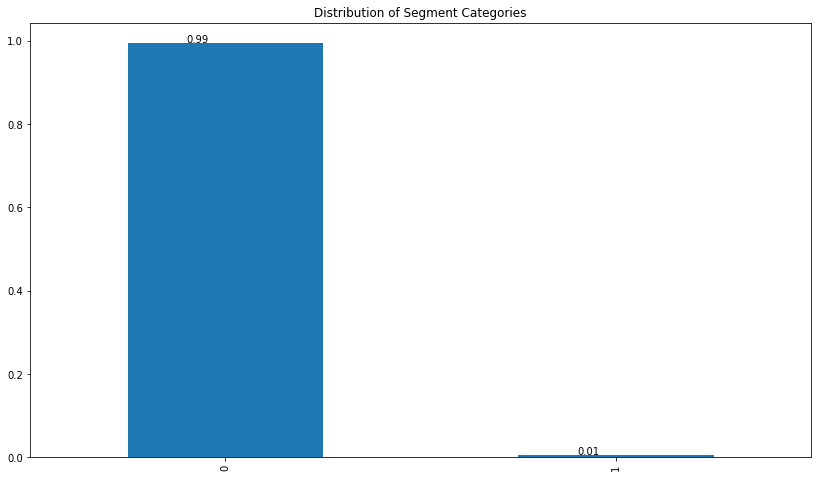

In [8]:
ax = segments['do_not_track'].value_counts(normalize=True).plot(kind='bar',
                                    figsize=(14,8),
                                    title="Distribution of Segment Categories")

for index, value in enumerate(segments['do_not_track'].value_counts(normalize=True)):
    ax.text(index-0.1, value+0.002, "{:.2f}".format(value))

In [13]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer("english")
# fit the vectorizer using the text data
tfid = tfid_vectorizer.fit(segments['segments'])
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

tfid_matrix = tfid_vectorizer.transform(segments['segments']).todense()
feature_names = tfid_vectorizer.get_feature_names()

# store the tf-idf array into pandas dataframe
df = pd.DataFrame(tfid_matrix, columns=feature_names)
df['output'] = segments['do_not_track']
df

,aaa,aaassuch,aad,abandon,abc,abid,abil,abita,abitacom,abl,abovedescrib,abovedesign,abroad,absolut,abu,abusi,academ,acc,accel,accept,access,accessupd,accid,accommod,accompani,accomplish,accord,accordingli,account,accountprofil,accredit,accumul,accur,accuraci,achiev,acknowledg,acount,acquir,acquisit,across,...,wwwstylecastercom,wwwstylecastermediagroupcom,wwwthecarconnectioncom,wwwthedmaorg,wwwtrustecomwatchdog,wwwuhedu,wwwusplaystationcom,wwwvikingscom,xbox,xcompanycom,xi,xii,xiii,xiv,xp,xrate,xyz,yahoo,ye,year,yet,york,youd,youll,young,younger,yourcaliforniaprivacyrightscom,yourperson,yourschooledu,youtub,youv,zack,zackscom,zealand,zero,zip,zipscen,zipscenecomprivaci,zone,output
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09901,0.032059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.073130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153661,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.198307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [14]:
#Split data using 30%/70% split
segments_train, segments_test, targets_train, targets_test = train_test_split(df[feature_names], df['output'], test_size=0.3, random_state=0)

In [15]:
alpha_list = np.linspace(0.1,3,30)
alpha_list = np.around(alpha_list, decimals=4)
alpha_list

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])

In [16]:
kf = KFold(n_splits=5, random_state=0, shuffle=False)
params = {'C': alpha_list,
          'random_state': [0]}

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [45]:
classifier = LinearSVC(random_state=0)
cross_val_score(classifier, segments_train, targets_train, cv=kf)

array([0.99811676, 0.99811676, 1.        , 0.99435028, 0.99811321])

In [46]:
grid_no_up = GridSearchCV(classifier, param_grid=params, cv=kf, scoring='recall_macro').fit(segments_train, targets_train)
print(grid_no_up.best_params_)
print(grid_no_up.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and 

{'C': 0.6, 'random_state': 0}
0.9236204878926996


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


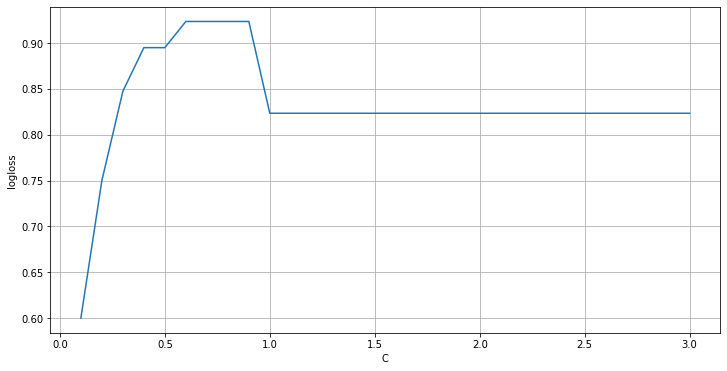

In [47]:
results = pd.DataFrame()
# collect parameter list
results['alpha'] = grid_no_up.cv_results_['param_C'].data
# collect test scores
results['score'] = grid_no_up.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['alpha'], results['score'])
plt.xlabel('C')
plt.ylabel('logloss')
plt.grid()

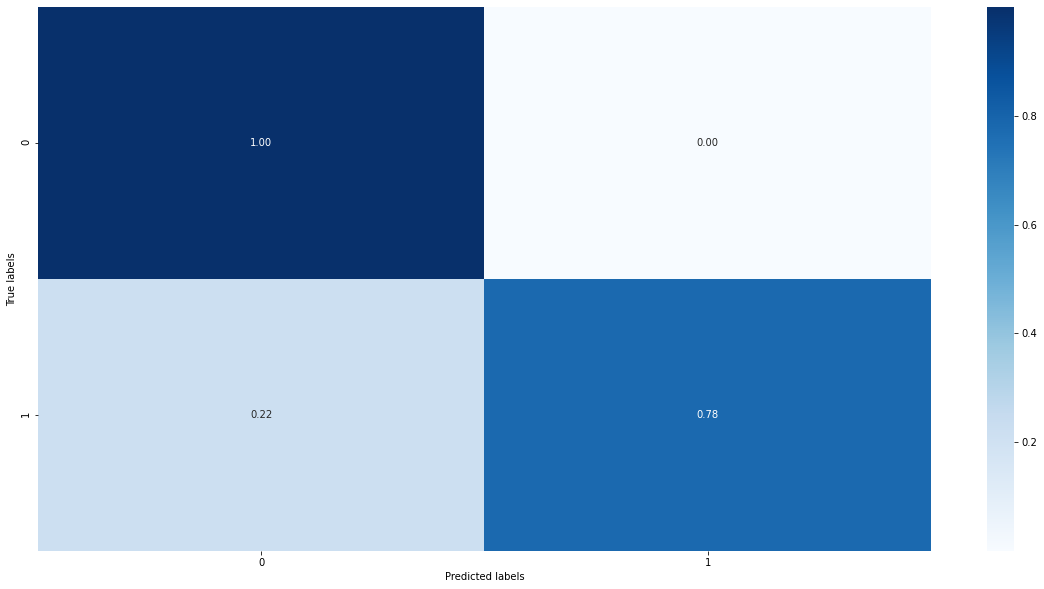

In [48]:
grid_no_up_preds = grid_no_up.best_estimator_.predict(segments_test)
#labels = segments['do_not_track'].unique()
cm = confusion_matrix(targets_test.astype(str), grid_no_up_preds.astype(str) )
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
#ax.set_xticklabels([''] + labels, rotation=90)
#ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [24]:
#Quick diagnostics
print(classification_report(targets_test.astype(str),grid_no_up_preds.astype(str)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1129
           1       0.88      0.78      0.82         9

    accuracy                           1.00      1138
   macro avg       0.94      0.89      0.91      1138
weighted avg       1.00      1.00      1.00      1138



In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [27]:
imba_pipeline = make_pipeline(SMOTE(random_state=0), 
                              LinearSVC(random_state=0))

new_params = {'linearsvc__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf).fit(segments_train, targets_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [28]:
print(grid_imba.best_params_)
print(grid_imba.best_score_)

{'linearsvc__C': 0.1, 'linearsvc__random_state': 0}
0.9988693458408842


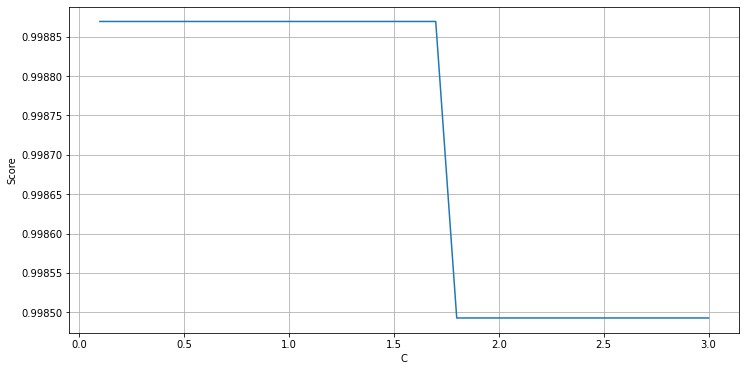

In [29]:
results = pd.DataFrame()
# collect alpha list
results['C'] = grid_imba.cv_results_['param_linearsvc__C'].data
# collect test scores
results['score'] = grid_imba.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['C'], results['score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

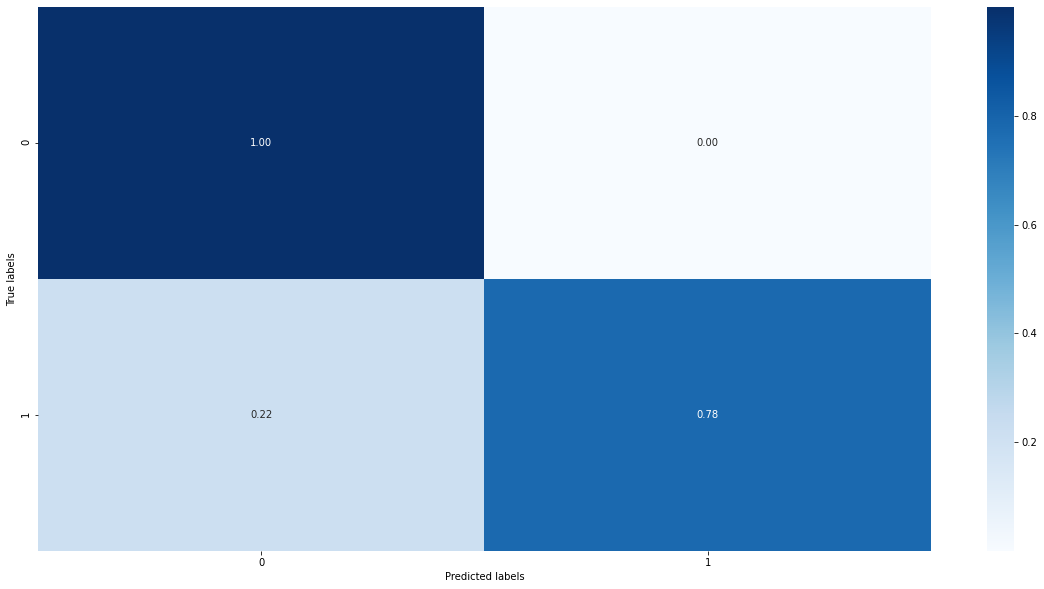

In [32]:
grid_imba_preds = grid_imba.best_estimator_.named_steps['linearsvc'].predict(segments_test)
#labels = segments['category_name'].unique()
cm = confusion_matrix(targets_test.astype(str), grid_imba_preds.astype(str))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
#ax.set_xticklabels([''] + labels, rotation=90)
#ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [34]:
#Quick diagnostics
print(classification_report(targets_test.astype(str),grid_imba_preds.astype(str)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1129
           1       0.88      0.78      0.82         9

    accuracy                           1.00      1138
   macro avg       0.94      0.89      0.91      1138
weighted avg       1.00      1.00      1.00      1138



In [35]:
smote = SMOTE('minority', random_state=0)
segments_smote, targets_smote = smote.fit_sample(segments_train, targets_train)
smote_df = pd.concat([pd.DataFrame(segments_smote, columns=feature_names), pd.DataFrame(targets_smote, columns=['output'])], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [36]:
smote_df['output'].value_counts()

1    2639
0    2639
Name: output, dtype: int64

In [37]:
#paramater selection
start_time = time.time()

parameters = [{'C': [0.001, 0.01, 0.1, 1, 10],
              'degree': [2, 3, 4],
              'kernel': ['rbf', 'poly', 'sigmoid'],
              'gamma':  [0.001, 0.01, 0.1, 1, 10],
              }]

params = {'C': alpha_list,
          'random_state': [0]}

gs_clf = GridSearchCV(classifier, params, n_jobs=-1, cv=kf, verbose=1)
gs_clf = gs_clf.fit(smote_df[feature_names],smote_df['output'])
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')
print("Best parameter: ",gs_clf.best_params_)
print("Best score: ",gs_clf.best_score_) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   27.3s finished


Done training in 27.721680402755737 seconds.
Best parameter:  {'C': 0.1, 'random_state': 0}
Best score:  0.9996212121212121


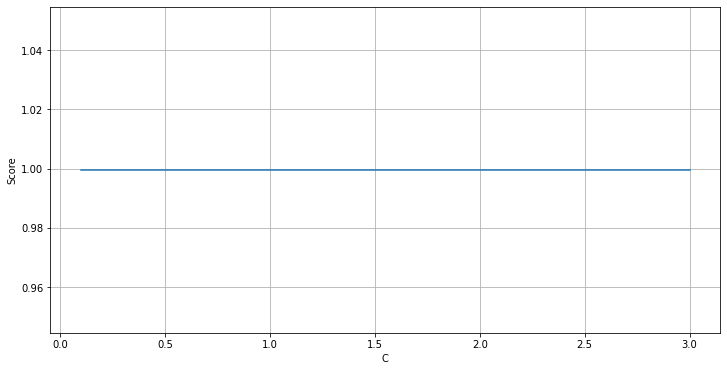

In [38]:
results = pd.DataFrame()
# collect alpha list
results['C'] = gs_clf.cv_results_['param_C'].data
# collect test scores
results['score'] = gs_clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['C'], results['score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

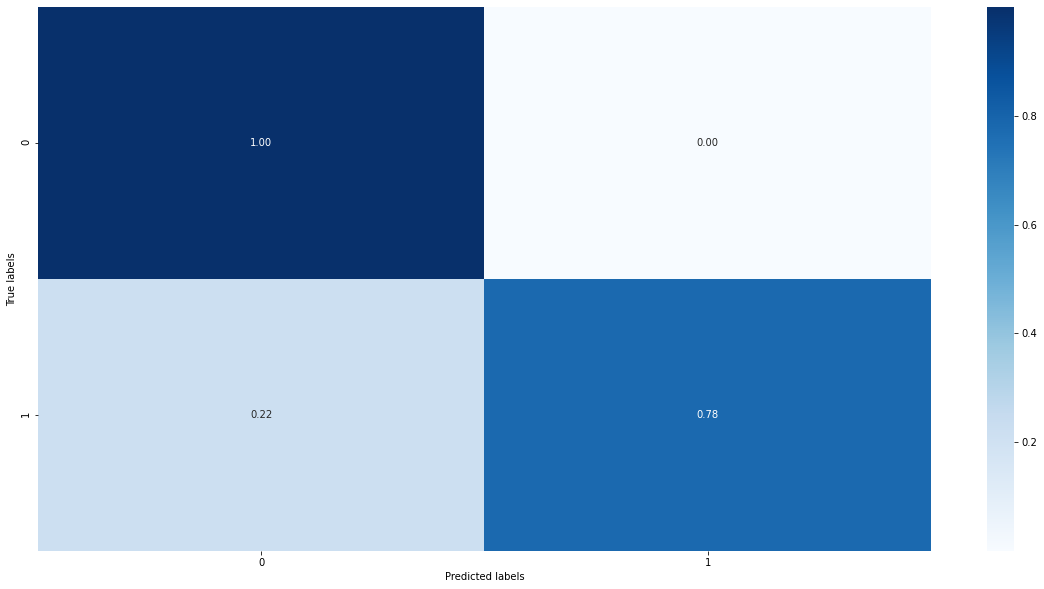

In [40]:
preds = gs_clf.predict(segments_test)
#labels = segments['category_name'].unique()
cm = confusion_matrix(targets_test.astype(str), preds.astype(str))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (20, 10)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
#ax.set_xticklabels([''] + labels, rotation=90)
#ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

In [41]:
#Quick diagnostics
print(classification_report(targets_test.astype(str),preds.astype(str)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1129
           1       0.88      0.78      0.82         9

    accuracy                           1.00      1138
   macro avg       0.94      0.89      0.91      1138
weighted avg       1.00      1.00      1.00      1138

